# 2. Extracting Text from PDF using Python

A reason that Python is such a popular programming language is because the community has created packages (programs) for almost anything you can think of. 

In the notebook, we will be using a python package that allows the user to extract text from pdfs. 

------------------

## Preamble: Download this Google Colab Notebook to your Google Drive

Before we begin, we want to **copy this Google Colab notebook to our Google Drive before we begin** in order to run this notebook. This also will allow you to make any modifications to the notes or the code as you wish. 

To copy this Google Colab notebook to your Google Drive:

1. Click the copy_to_drive.png button at the top of the Google Colab webpage.
2. A message may appear that says Google Colab wants to open the copied Google Colab notebook in a new tab. Click the button that says open the copied notebook in a new tab if this comes up. 
3. **Quit the original tab with the original Google Colab notebook** so that we dont get mixed up with notebooks. 

We are now ready to run this Google Colab Notebook. 

**NOTE**: You can find this notebook in your Google Drive now in a new folder called ```Colab Notebooks```. 

------------------

## 1. Coping PDF files into Google Colabs

**To begin**, click the Files folder icon to the left of the colab page

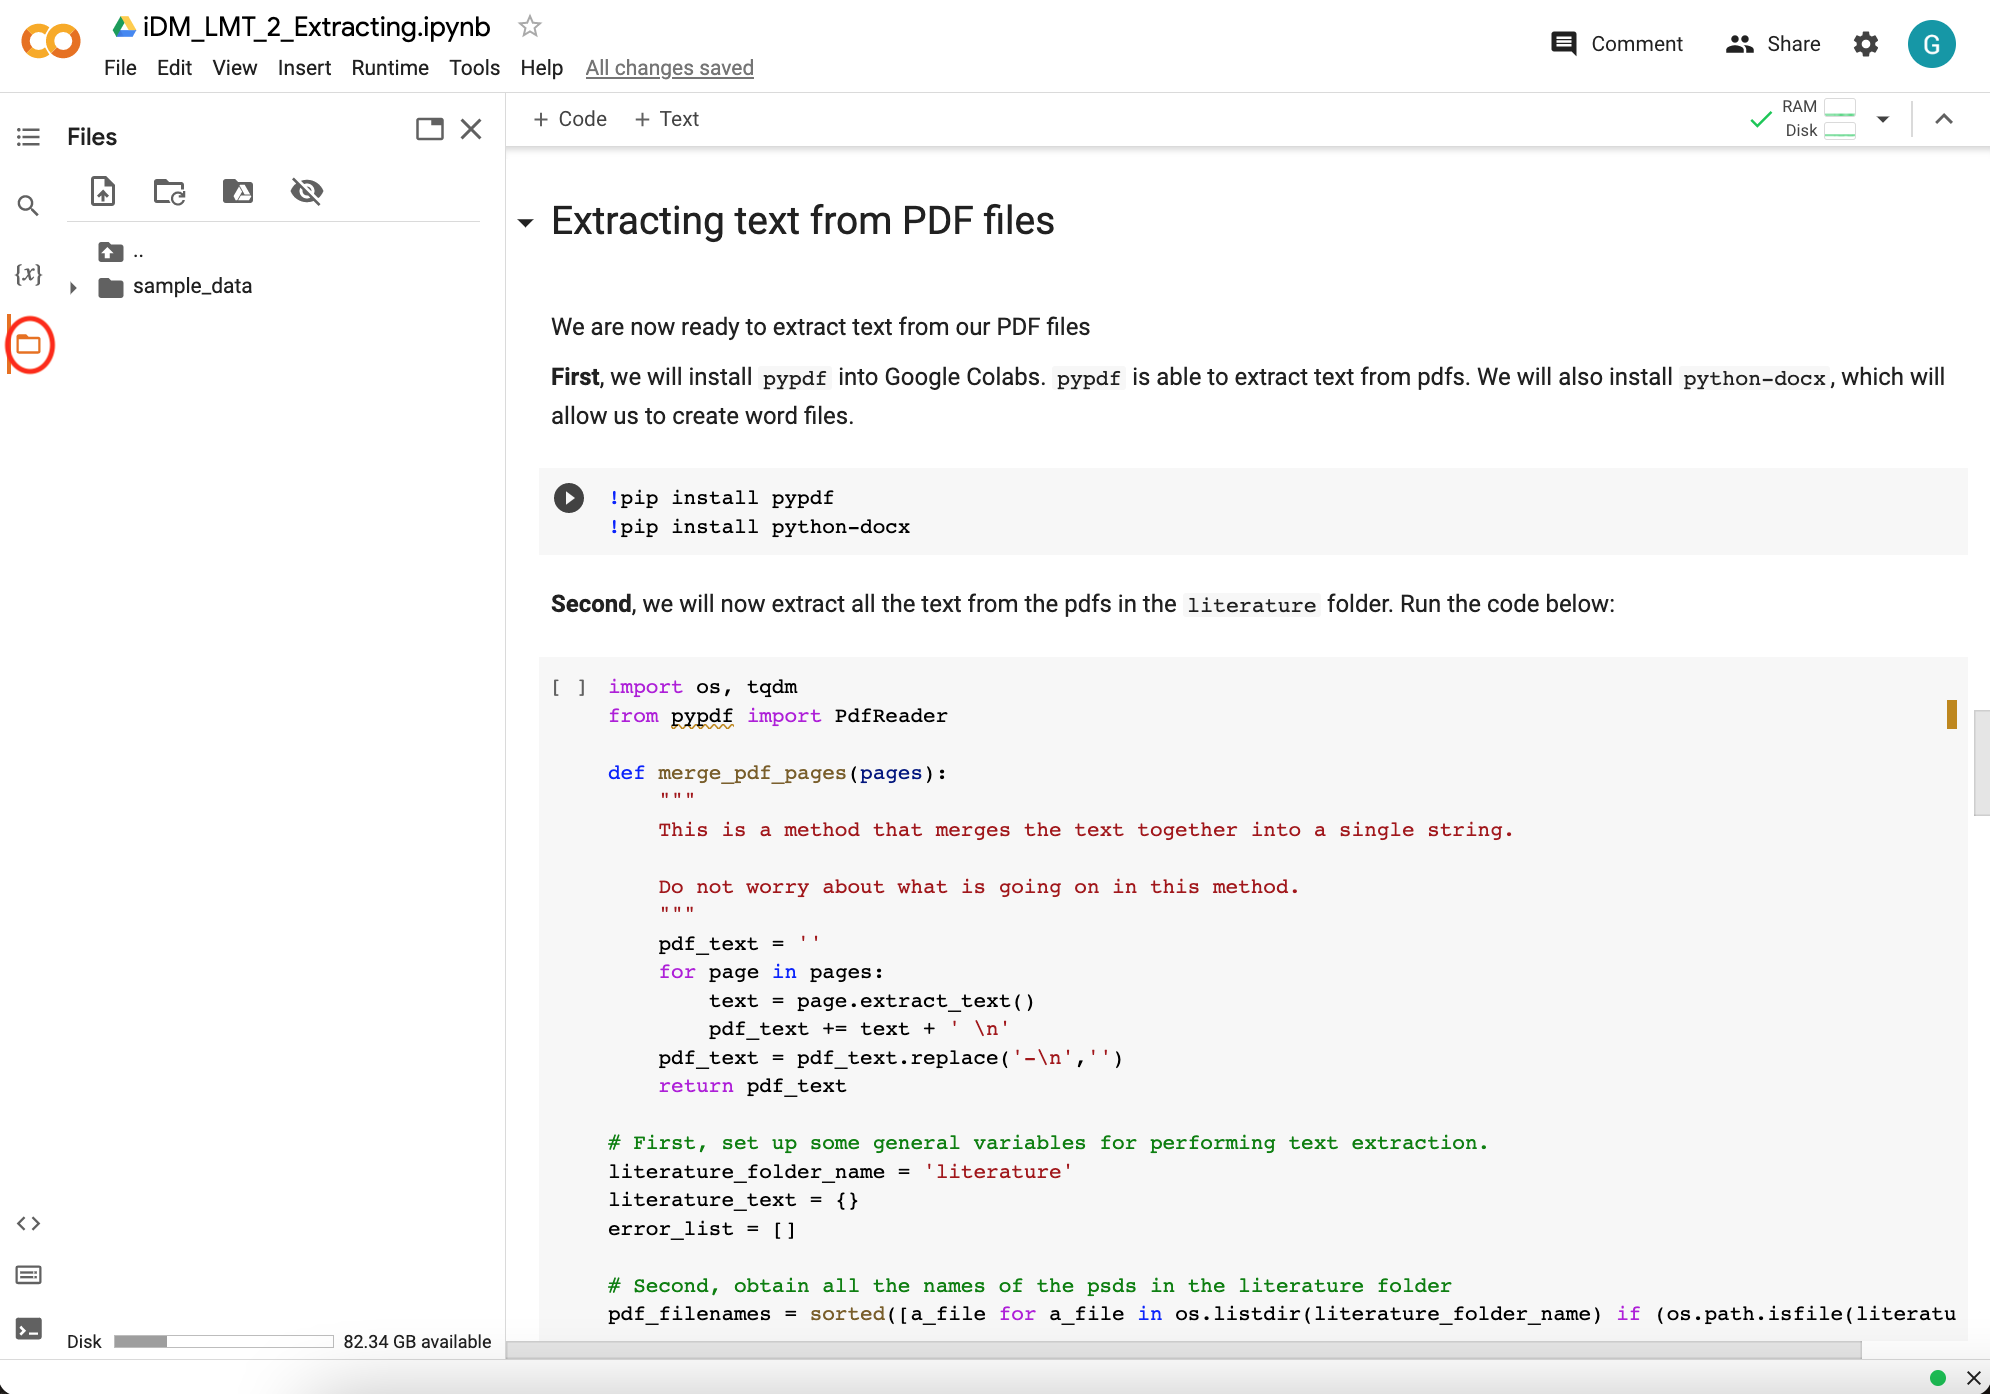

This will show all the files and folders that we can work with. 

**Second**, we also need to move our "terminal" here as well. To do this, we will run ```os.chdir('/content')``` line of code below:



In [ ]:
import os, shutil
os.chdir('/content')

We can check that our "terminal" is here as well by running the code below:

In [ ]:
os.listdir('.')

You should be able to see the ```sample_data``` folder included in this list. 

**Third**, we want to copy all the pdf files that you downloaded from Scopus into Google Colab. To do this, click the upload.png upload button and move into your ```downloads``` folder that contains the PDF files you downloaded from Scopus. 

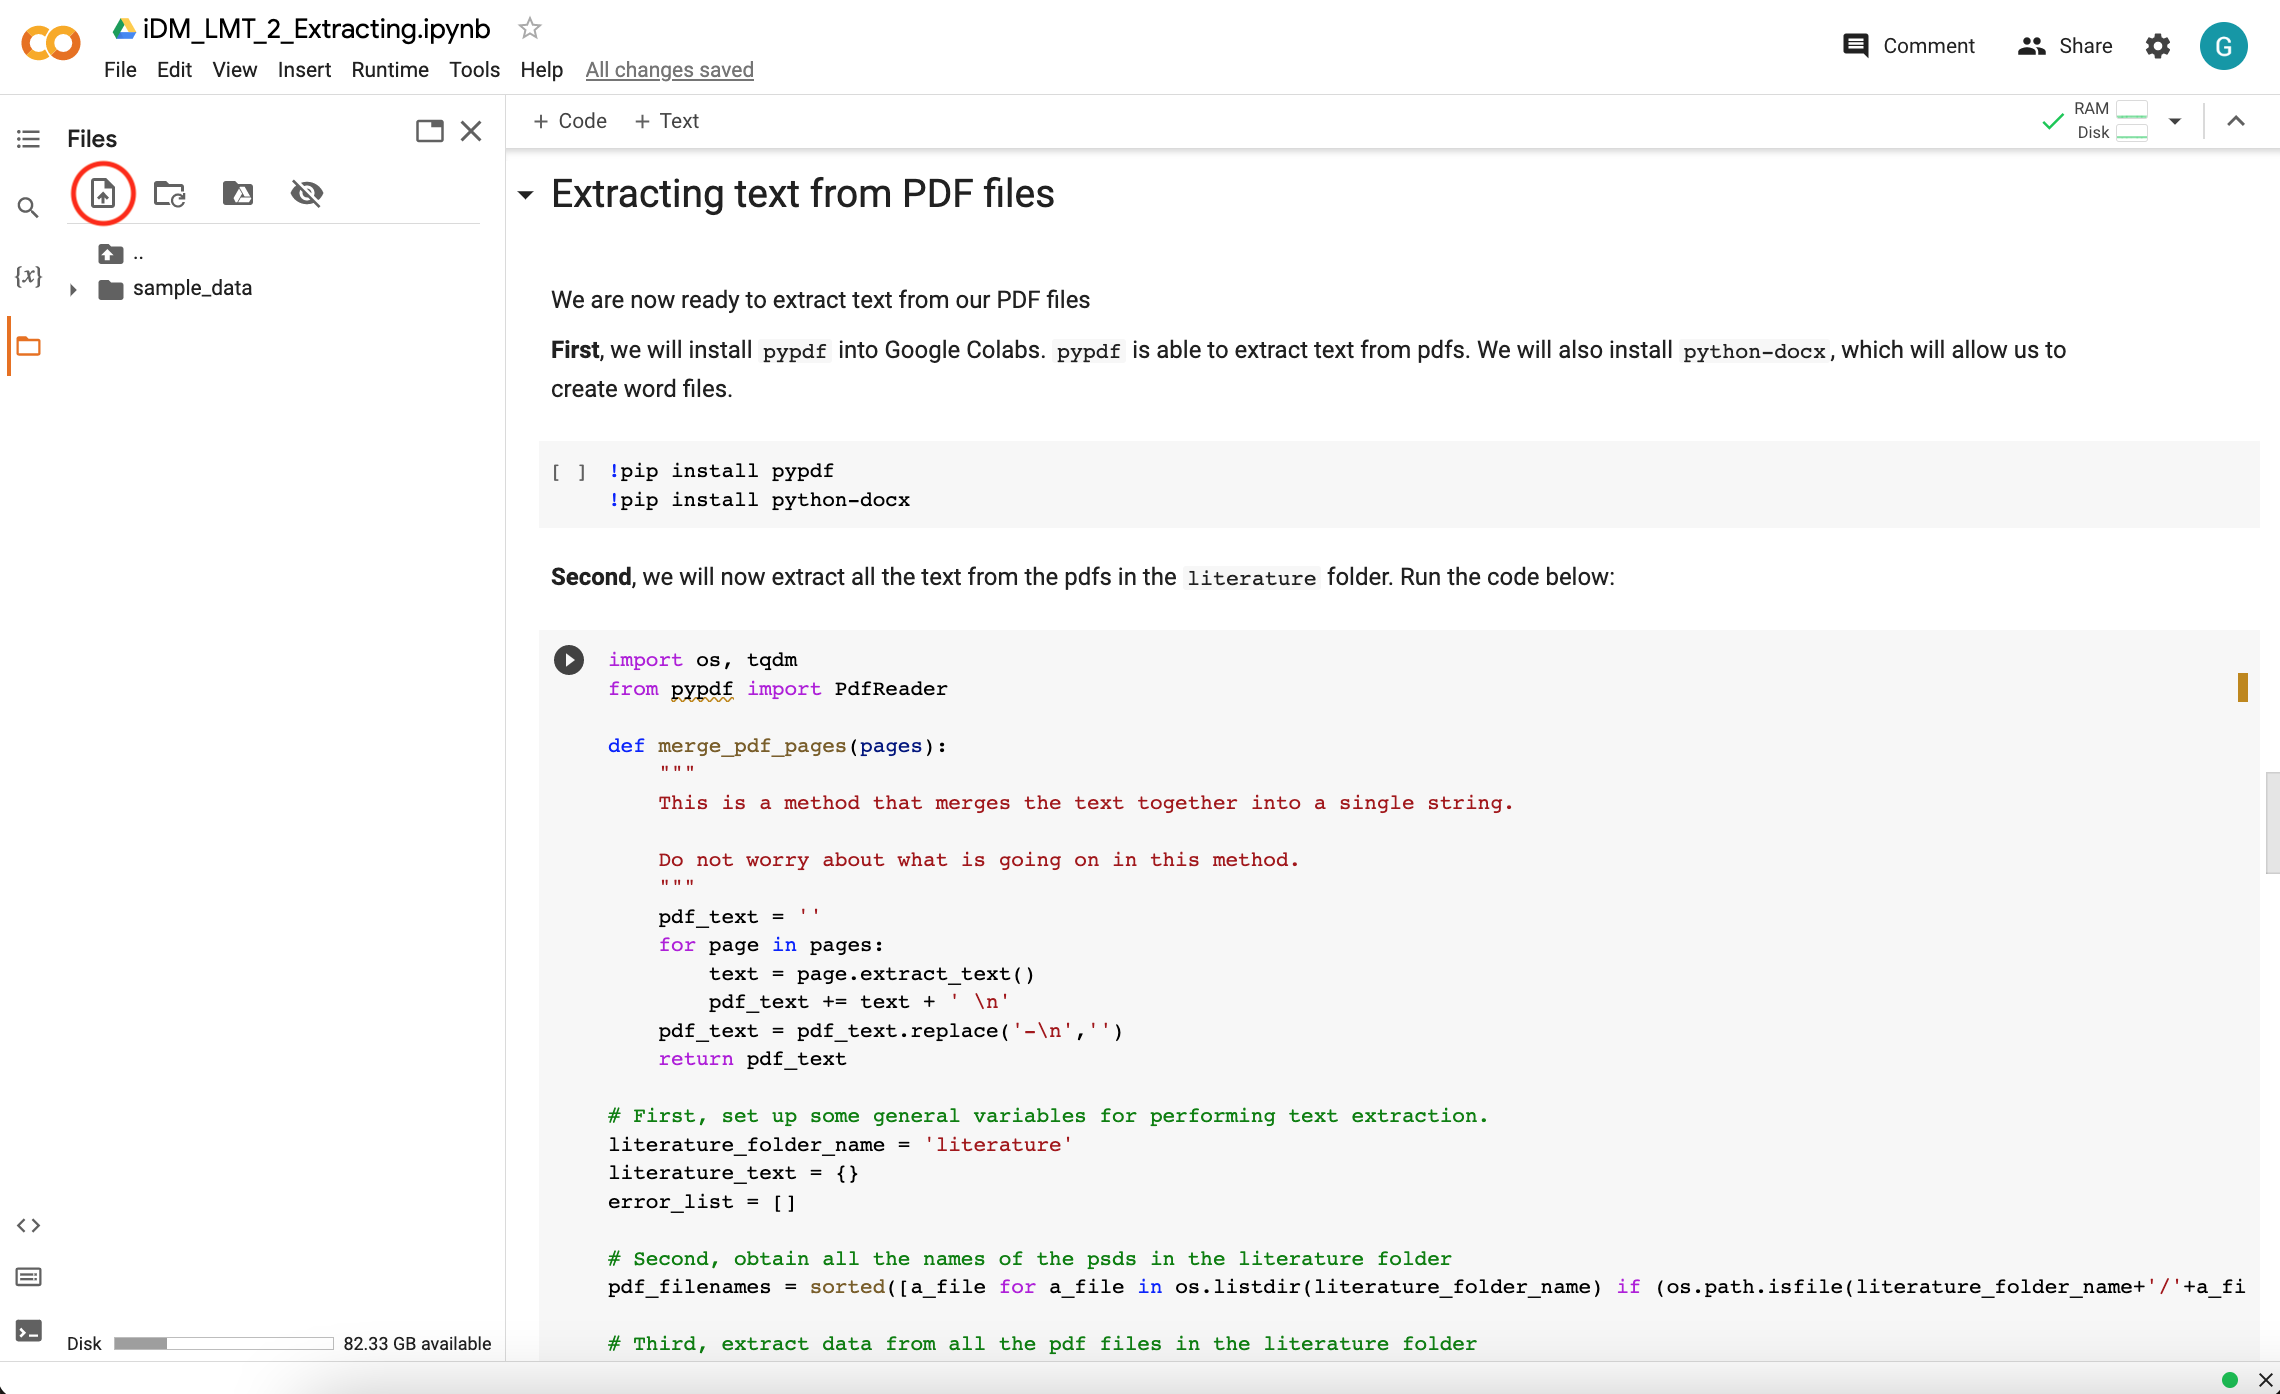

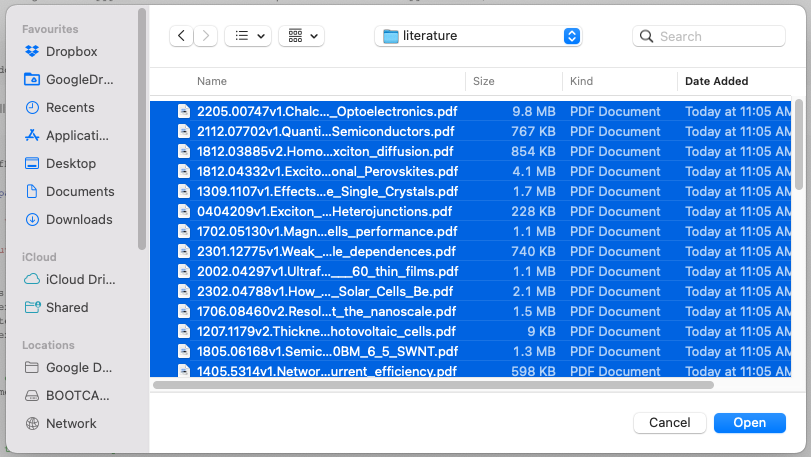

You may see this message once you press ```Open```

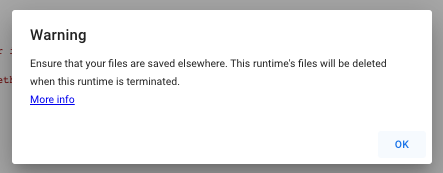

You will see your PDF files being uploaded in the ```Files``` column

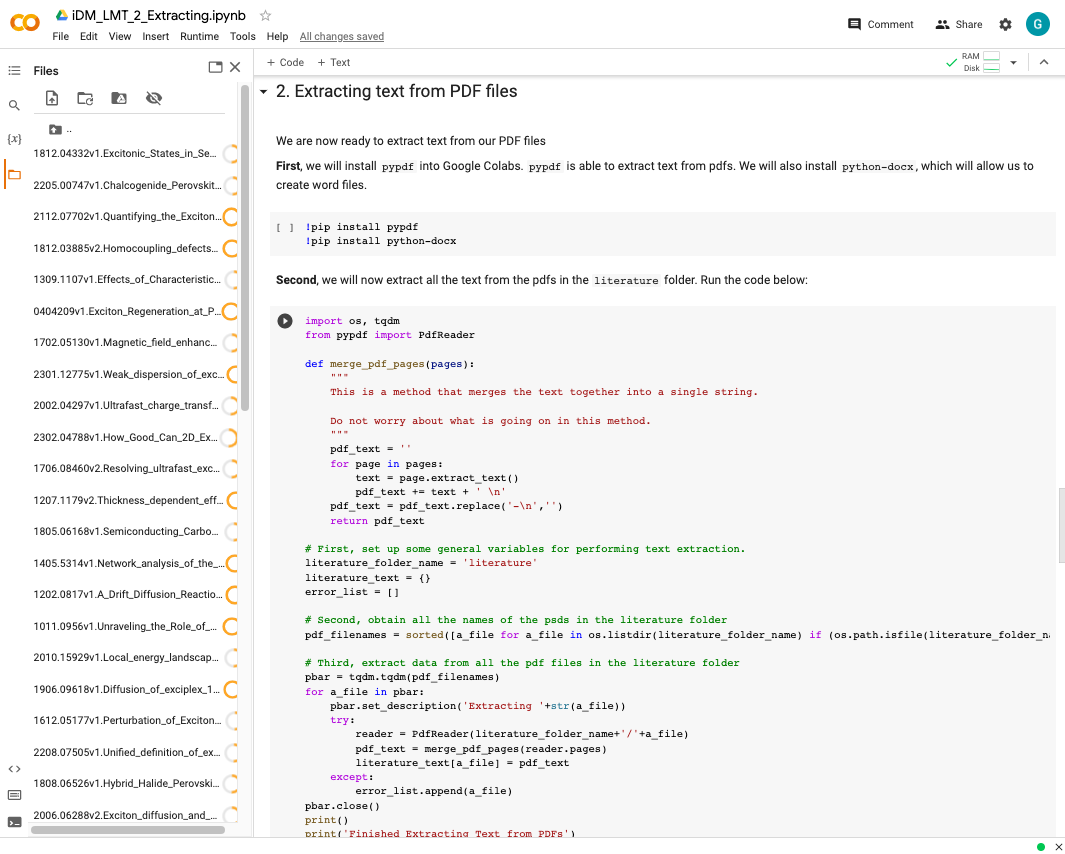

**Wait until ALL the PDFs have been uploaded**. This is complete when you see no PDF file with circles next to them. 

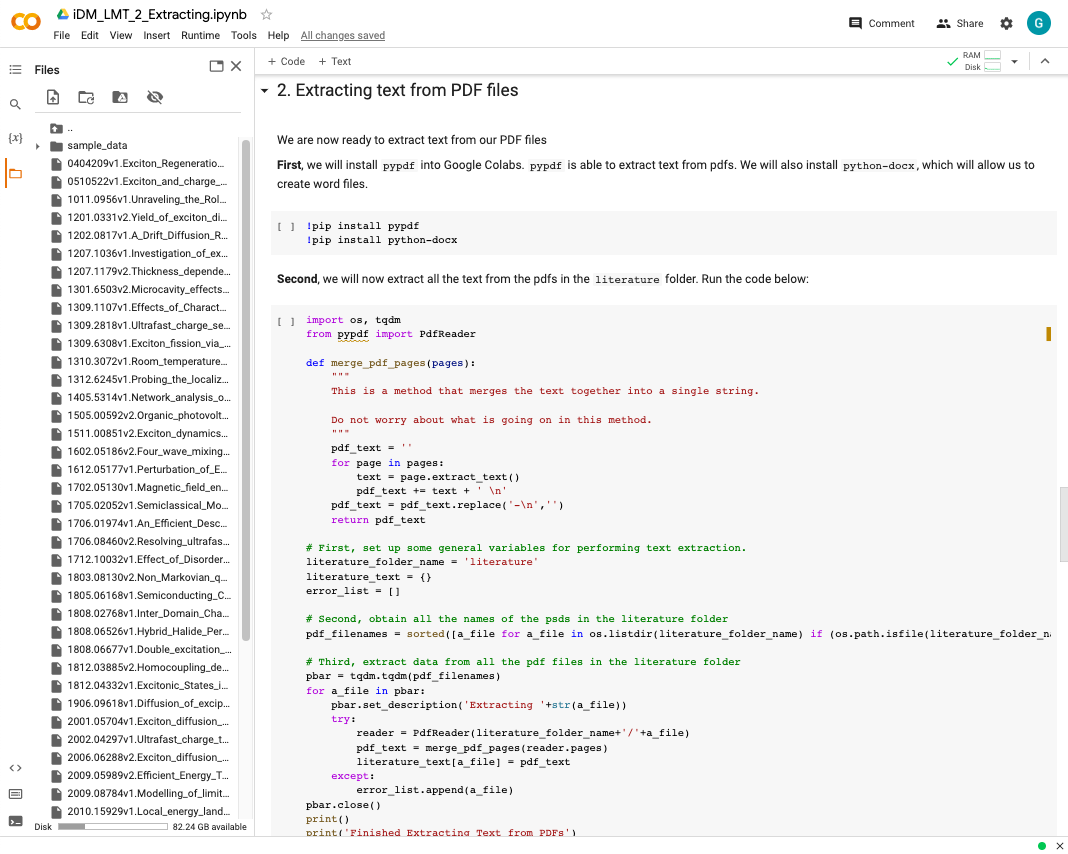

Your PDFs will be uploaded to Google Colabs. **Once all the PDFs have been copied, we then run the code below**. This will move all the PDFs you have copied to Google Colabs into a new folder called ```literature```. 

In [ ]:
import tqdm

# First, make a folder called literature if it does not already exist
literature_folder_name = 'literature'
if not os.path.exists(literature_folder_name):
    os.makedirs(literature_folder_name)

# Second, move all pdf files into the literature folder
pdf_fileanmes = sorted([a_file for a_file in os.listdir(".") if (os.path.isfile(a_file) and a_file.endswith('.pdf'))])
if len(pdf_fileanmes) > 0:
    pbar = tqdm.tqdm(pdf_fileanmes)
    for a_file in pbar:
        pbar.set_description('Moving '+str(a_file))
        shutil.move(a_file, literature_folder_name+'/'+a_file)
else:
    print('There were no pdfs to move to the '+str(literature_folder_name)+' folder.')

If you click the refresh.png refresh button, you will see all the PDFs have disappeared and a ```literature``` folder has appeared. If you click on the ```literature``` folder now, it will now contain the PDFs.

## 2. Extracting text from PDF files

We are now ready to extract text from our PDF files

**First**, we will install ```pypdf``` into Google Colabs. ```pypdf``` is able to extract text from pdfs. We will also install ```python-docx```, which will allow us to create word files. 

In [ ]:
!pip install pypdf
!pip install python-docx

**Second**, we will now extract all the text from the pdfs in the ```literature``` folder. Run the code below:

In [ ]:
import os, tqdm
from pypdf import PdfReader

def merge_pdf_pages(pages):
    """
    This is a method that merges the text together into a single string. 
    
    Do not worry about what is going on in this method.
    """
    pdf_text = ''
    for page in pages:
        text = page.extract_text()
        pdf_text += text + ' \n'
    pdf_text = pdf_text.replace('-\n','')
    return pdf_text

# First, set up some general variables for performing text extraction.
literature_folder_name = 'literature'
literature_text = {}
error_list = []

# Second, obtain all the names of the psds in the literature folder
pdf_filenames = sorted([a_file for a_file in os.listdir(literature_folder_name) if (os.path.isfile(literature_folder_name+'/'+a_file) and a_file.endswith('.pdf'))])

# Third, extract data from all the pdf files in the literature folder
pbar = tqdm.tqdm(pdf_filenames)
for a_file in pbar:
    pbar.set_description('Extracting '+str(a_file))
    try:
        reader = PdfReader(literature_folder_name+'/'+a_file)
        pdf_text = merge_pdf_pages(reader.pages)
        literature_text[a_file] = pdf_text
    except:
        error_list.append(a_file)
pbar.close()
print()
print('Finished Extracting Text from PDFs')

# Fourth, indicate if there were any problems with extracting text from pdfs
if len(error_list) > 0:
    print('=========================================')
    print('The following pdfs could not have text extracted from them:')
    print()
    for error_file in error_list:
        print(error_file)
    print('=========================================')
else:
    print('Text could be extracted from all pdfs with no problems.')

We have now extracted the text in the pdfs! Now lets do stuff with it

**Third**, lets scan the literature for keywords we are interested in. **Run the code below to create the keywords list**. 

In [ ]:
keywords = ['exciton', 'diffusion', 'coefficient']

Lets now scan the literature for these keywords. **Run the code below to locate all the keywords in each PDF**.




In [ ]:
import re
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH

def find_keywords(pdf_text, keywords):
    """
    This method is designed to locate all the keywords in a string of text.
    """
    all_keyword_indices_in_text = []
    for keyword in keywords:
        all_keyword_indices_in_text += [(m.start(), m.end()) for m in re.finditer(keyword, pdf_text)]
    return sorted(all_keyword_indices_in_text)

# First, set up some general variables for recording data about keywords
keywords_in_literature_text = {pdf_filename: None for pdf_filename in literature_text.keys()}

# Second, determine all the places in the PDF where keywords are found. 
pbar = tqdm.tqdm(sorted(literature_text.items()))
for pdf_filename, pdf_text in pbar:
    pbar.set_description('Analysing Keywords in '+str(pdf_filename))
    all_keyword_indices_in_text = find_keywords(pdf_text,keywords)
    keywords_in_literature_text[pdf_filename] = all_keyword_indices_in_text
pbar.close()
print()
print('Finished Identifying Keywords from PDFs')

We have now analysed each PDF. We can now do stuff with this data. 

**Fourth, Run the code below to create word files that contain snippets of text where the keywords of interest appear**

In [ ]:
def already_been_printed(phsi, phei, printed_segments):
    """
    This method is used to determine what has already been printed. 

    Do not worry about what is going on in this method.
    """
    for start_index, end_index in printed_segments:
        if (start_index <= phsi <= end_index) and (start_index <= phei <= end_index):
            return True
    return False

# First, set up some general variables for running this script
literature_keyword_summary_name = 'literature_keyword_summary'
print_hangover_no = 200

# Second, create a new folder to save keyword summary docx files to.
if not os.path.exists(literature_keyword_summary_name):
    os.makedirs(literature_keyword_summary_name)

# Third, print what the keywords that will be searched for in this script.
print('##################################')
print('keywords: '+str(keywords))
print('##################################')

# Fourth, save the summary of keywords found in the text into docx files.
pbar = tqdm.tqdm(sorted(literature_text.keys()))
for pdf_filename in pbar:

    # 4.1: Create the word document. 
    docx_filename = pdf_filename.replace('.pdf','.docx')
    pbar.set_description('Saving to file: '+str(docx_filename))
    document = Document()
    document.add_heading(pdf_filename)
    document.add_paragraph()

    # 4.2: Collect the text from the pdf, and the positions of keywords identified in the text
    pdf_text = literature_text[pdf_filename]
    all_keyword_indices_in_text = keywords_in_literature_text[pdf_filename]

    # 4.3: Write all the summaries involving keywords from the pdf into the docx file
    printed_segments = []
    for start_index, end_index in all_keyword_indices_in_text:
        phsi = start_index - print_hangover_no
        if phsi < 0:
            phsi = 0
        phei = end_index + print_hangover_no
        if phei > (len(pdf_text)-1):
            phei = len(pdf_text)-1
        if already_been_printed(phsi, phei, printed_segments):
            continue
        else:
            printed_segments.append((phsi,phei))
        insept_in_text = pdf_text[phsi:phei]
        insept_in_text = insept_in_text.replace('\n',' ')
        paragraph = document.add_paragraph()
        paragraph.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
        for word in insept_in_text.split():
            try:
                run = paragraph.add_run(word+' ')
            except Exception as exception:
                continue
            if any([(keyword in word) for keyword in keywords]):
                run.bold = True

    # 4.4: Save the docx file
    document.save(literature_keyword_summary_name+'/'+docx_filename)
pbar.close()
print()
print('Finished Saving the DOCX files contains summaries of keywords')

If you click the refresh.png refresh button, you will see a new ```literature_keyword_summary``` folder. This folder contains docx files that contain segments of the paper that include the keywords of interest. 

**Fifth**, we can now convert this ```literature_keyword_summary``` folder into a zip file and download it. **Run the code below**

**NOTE**: It may take time to download the ```literature_keyword_summary.zip``` file to your computer.

In [ ]:
!zip -r literature_keyword_summary.zip literature_keyword_summary > .output.txt
from google.colab import files
files.download('literature_keyword_summary.zip') 

You will now have downloaded a zip file called ```literature_keyword_summary.zip```. If you open this zip file, you will see it contains many word files, all of which contain snippets of each pdf file. 

**Once you have completed this**, move on to the ```iDM_LMT_2_Extracting.ipynb``` notebook, called ```Highlighting Keywords in PDFs using Python```